In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

**Reddit Posts** 
- Reddit data will be provided by the topic and clustering data.\
- It will be in the same format, but include a community and topic label for each row. \
- For now, we will just view the data. 

In [2]:
# retrieve reddit data
df = pd.read_csv('../koigawa_milestone_II/milestone_II/community_output_gme.csv')
df['date'] = df['date'].astype('datetime64[ns]')

#capture timeframe of reddit data
MIN_DATE = df['date'].min()
MAX_DATE = df['date'].max()

df.head()

,Unnamed: 0,id,author,date,selftext,community_label
0,0,kqfajb,TitsDownOnly,2021-01-04 19:02:26,After watching this I took a position RIGHT AW...,7
1,1,kqvp7l,TitsDownOnly,2021-01-05 10:19:59,This guy explained exactly how to take a posit...,7
2,2,kuo3w1,TitsDownOnly,2021-01-10 21:59:17,"After some downwards movement, I think everyb...",7
3,5,kyodi5,TitsDownOnly,2021-01-16 18:31:13,The enormous moves that are right now expected...,7
4,6,l09lgy,TitsDownOnly,2021-01-19 02:03:35,By looking at what happened in 2008 with the i...,7


**Stock Price History (daily_stock_price.py)**\
Retrives the stock prices for the ticker and timeline provided.
- The best index/stock determined through manual inspection
- Alternative, try and extract reference stock / indicies

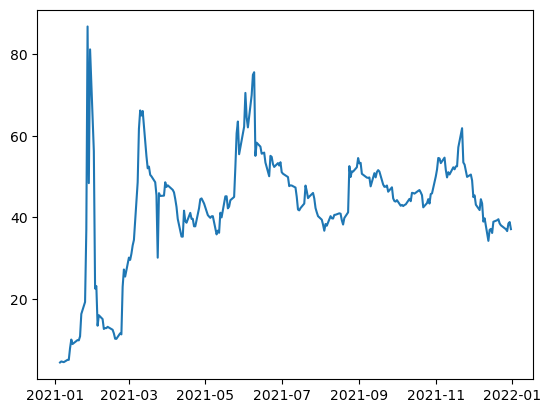

In [3]:
# index / stock options 
    # VOO: S&P 500 index
    # FSMDX: Mid cap index fund
    # SFSNX: Mid cap index fund 
    # XLK: Technology sector stock index 
    # MEME: Meme stock index 
    # GME: Gamestop stock

# retrive stock price data, saves csv and chart png
from daily_stock_price import get_stock_prices
TICKER = 'GME'
get_stock_prices(ticker = TICKER, start = MIN_DATE, end = MAX_DATE)

**Pre-Processing Market and Reddit Data (supervised_data_prep.py)**
- Stock price data will fill missing dates with previous dates stock price (ffill over days when market is closed). 
- Reddit data will be joined to stock price data.
- Missing reddit dates are added as zeros.  
- Dummy cluster and topic labels are added to reddit data temporarily.
- Reddit data is grouped by date and community / topic, values are counted.

In [4]:
# submissions_reddit file will be provided with community and topic labels
from supervised_data_prep import process_financial_data, process_reddit_data, combine_data

# will process stock data and save a csv 'stock_prices_clean.csv
process_financial_data('stock_prices.csv', MIN_DATE, MAX_DATE)

# will process reddit data (including dummy topics / clusters) and save as csv 'community_discussion_counts_clean.csv'
process_reddit_data('../koigawa_milestone_II/milestone_II/community_output_gme.csv')

# combine market and reddit data
combine_data('community_discussion_counts_clean.csv', 'stock_prices_clean.csv')

**Visualize Community / Topic Activity**
- Viewing the comunity group & topic activity and changes in the stock price.

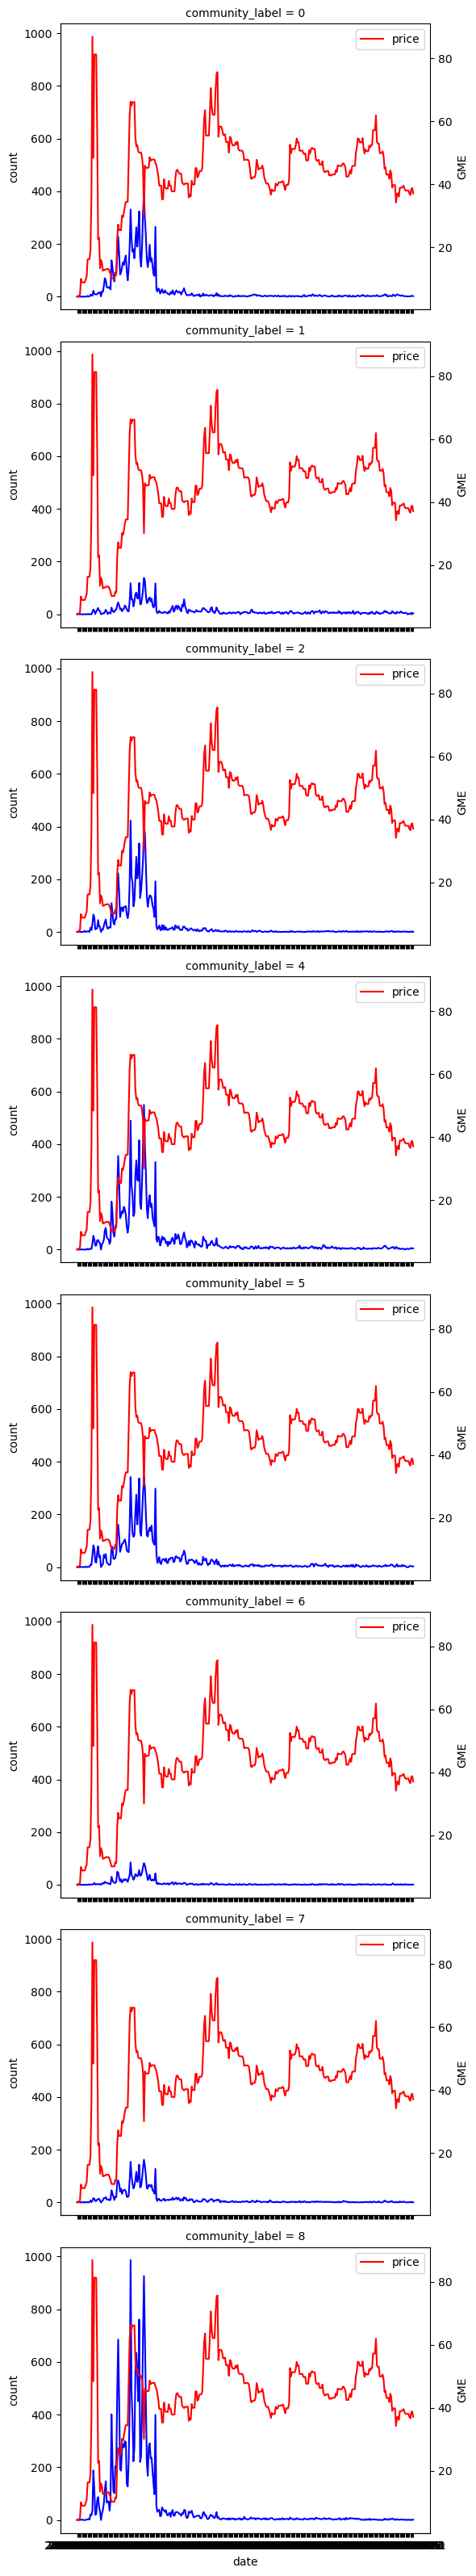

In [5]:
df = pd.read_csv('combined_data.csv')
feature_cols = [c for c in df.columns if len(c)==1]
df = pd.melt(df, id_vars=['date', TICKER], value_vars=feature_cols, value_name='count', var_name='community_label')

g = sns.FacetGrid(data=df, row="community_label", height=4, aspect=1.5)

# plotting function
def plot_dual_axis(data, **kwargs):
    ax = plt.gca()
    sns.lineplot(data=data, x='date', y='count', ax=ax, color='b', label='count')
    ax2 = ax.twinx()
    sns.lineplot(data=data, x='date', y=TICKER, ax=ax2, color='r', label='price')

# create grid for each community and topic label
g.map_dataframe(plot_dual_axis)
plt.show()

**Model Evaluation (supervised_modeling.py)**\
- Community/topic activity is compared with market data.\
- This is also explored within three different supervised learning models.\
- Output is the r2 value for each model and community/topic.\
- Hyperparameter tuning embedded in modelling will occur after preferred model is selected. 

In [8]:
from supervised_modeling import model_comparison

# returns r2 values for each model / community&topic combination when compared 
# against the selected market data
results = model_comparison(pd.read_csv('combined_data.csv'), TICKER, features=['0', '1', '2', '3', '4', '5', '6', '7', '8'])

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\carld\miniconda3\envs\mads\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\carld\miniconda3\envs\mads\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carld\miniconda3\envs\mads\Lib\site-packages\sklearn\linear_model\_base.py", line 609, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carld\miniconda3\envs\mads\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\carld\miniconda3\envs\mads\Lib\site-packages\sklearn\utils\validation.py", line 1273, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\carld\miniconda3\envs\mads\Lib\site-packages\sklearn\utils\validation.py", line 1045, in check_array
    raise ValueError(msg)
ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.


**Visualize Model Results**\
- Using R2 to examine the extent to which the variance in stock / index price is explained by the variance in community activity. 

Text(0.5, 1.0, 'R2 Results of Community Activity Using Different Regression Models')

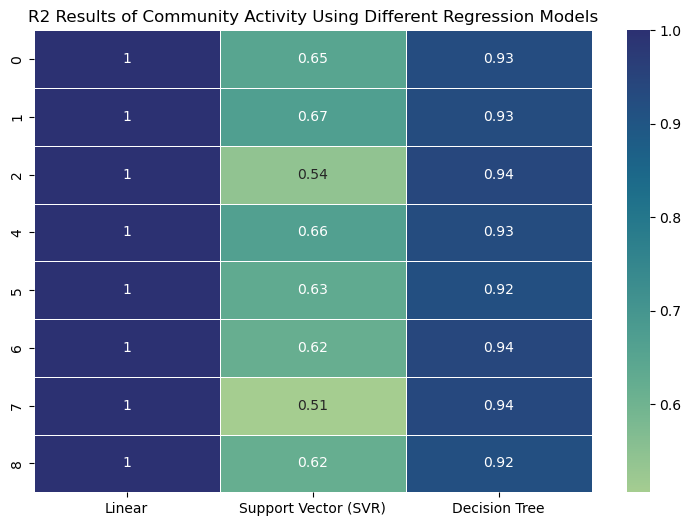

In [8]:
# heatmap of the results 
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(results, annot=True, linewidths=.5, ax=ax, cmap='crest')
plt.title('R2 Results of Community Activity Using Different Regression Models')